In [8]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import torch.utils
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


In [9]:
transform = transforms.ToTensor() # convertendo a imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carregando a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # criando um buffer para pegar os dados por parte

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # carregando a parte de treino do dataset
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # criando um buffer para pegar os dados por parte

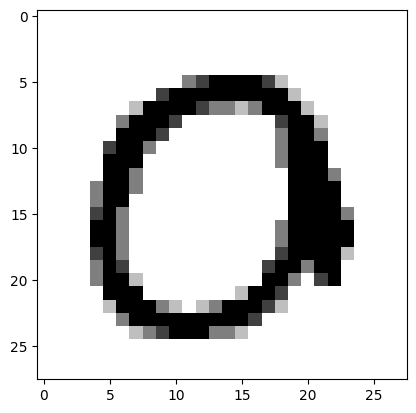

In [10]:
dataiter = iter(trainloader)  # iterador criado a partir de 'trainloader'
imagens, etiquetas = next(dataiter)  # obtém o próximo lote de imagens e etiquetas do iterador 'dataiter'
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [11]:
print(imagens[0].shape)  # verifica as dimensões do tensor de cada imagem
print(etiquetas[0].shape)  # verifica as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [12]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo,self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada: 784 neurônios que se ligam a 128  
        self.linear2 = nn.Linear(128, 64) # camada interna 1: 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2: 64 neurônios que se ligam a 10
        # não é necessário definir a camada de saída, pois só é preciso pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X))  # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X))  # função de ativação da camada interna 1 para a camada interna 2    
        X = self.linear3(X)  # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1)  # dados utilizados para calcular a perda

In [13]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)  # definindo a política de atualização dos pesos e da bias
    inicio = time()  # timer para calcular o tempo do treino

    criterio = nn.NLLLoss()  # definindo o criterio para calcular a perda
    EPOCHS = 10  # número de epochs que o algoritmo rodará
    modelo.train()  # ativação do modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0  # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1)  # convertendo as imagens para vetores de 28*28 casas
            otimizador.zero_grad()  # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device))  # colocando os dados no modelo
            perda_instantanea =  criterio(output, etiquetas.to(device))  # calculando a perda da epoch em questão

            perda_instantanea.backward()  # back propagation a partir da perda

            otimizador.step()  # atualizando os pesos e as bias

            perda_acumulada += perda_instantanea.item()  # atualizando a perda acumulada
            
        else: 
            print(f"Epoch {epoch+1} - Perda resultante: {perda_acumulada/len(trainloader)}")
    print(f"\nTempo de treino (em minutos) = {(time()-inicio)/60}")

In [14]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # desativar o autograd para acelerar a validacão
            with torch.no_grad():
                logps = modelo(img.to(device))  # output do modelo em escala logaritmica

            ps = torch.exp(logps)  # converte o output para escala normal
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab))  # converte o tensor em um número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred):  # compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas +=1
    
    print(f"Total de imagens testadas: {conta_todas}")
    print(f"\nPrecisão do modelo: {conta_corretas*100/conta_todas}")

In [15]:
modelo = Modelo()  # inicializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # modelo rodará na GPU se possível
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)